<a href="https://colab.research.google.com/github/ruthu06/Face-Recognition/blob/main/ML_GROUP13(AUG)_facerecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python dlib imutils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install face_recognition


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=be9e831645ea52a7276400dcc0f976c1eca2cb2af3dc31414022dbb8b37657c0
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 22.7 MB/s eta 0:00:00


In [ ]:
pip install Pillow


In [ ]:
# @title CONVERT HEIC TO JPEG
import os
import pyheif
from PIL import Image

# Define the directory containing images
input_directory = '/content/drive/MyDrive/Release'

# Loop through files in the input directory
for student_folder in os.listdir(input_directory):
    student_folder_path = os.path.join(input_directory, student_folder)
    for filename in os.listdir(student_folder_path):
       if filename.endswith(".HEIC"):  # Check if the file is a HEIC image
          heic_file_path = os.path.join(student_folder_path, filename)

        # Read the HEIC file
          heif_file = pyheif.read(heic_file_path)

        # Convert HEIC to JPEG
          jpeg_image = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )

        # Define the new file path for the converted JPEG
          jpeg_file_path = os.path.join(student_folder_path, os.path.splitext(filename)[0] + '.jpeg')

        # Save the converted image as JPEG
          jpeg_image.save(jpeg_file_path, 'JPEG', quality=95)

        # Remove the original HEIC file
          os.remove(heic_file_path)
          print(f"File '{filename}' converted and replaced with a JPEG.")


In [ ]:
# @title RE-SIZE
import os
import cv2
import dlib
import pyheif
from imutils import face_utils



# Define the face detector
face_detector = dlib.get_frontal_face_detector()

# Define the path to the main directory containing student subfolders
main_directory = '/content/drive/MyDrive/Release'

# Define the path to the directory where the cropped faces will be stored
output_directory = '/content/drive/MyDrive/resized_photos'

# Make the output directory if it doesn't already exist
os.makedirs(output_directory, exist_ok=True)


# Loop over all subfolders in the main directory
for student_folder in os.listdir(main_directory):
    student_folder_path = os.path.join(main_directory, student_folder)

    # Continue if not a directory
    if not os.path.isdir(student_folder_path):
        continue

    # Loop over all files in the student subfolder
    for filename in os.listdir(student_folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"): # Add/modify according to your image type
            # Load the image using OpenCV
            img = cv2.imread(os.path.join(student_folder_path, filename))

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect faces in the grayscale image
            rects = face_detector(gray, 1)

            # Loop over each face detected in the image
            for (i, rect) in enumerate(rects):
                # Convert the face rectangle to a bounding box
                (x, y, w, h) = face_utils.rect_to_bb(rect)

                # Let's add some padding around the face bounding box for capturing more context
                padding = 20 # Adjust this value based on your requirements
                (x, y, w, h) = max(x - padding, 0), max(y - padding, 0), w + padding, h + padding

                # Crop the face out of the image (ensure coordinates are within image bounds)
                face = img[y:min(y + h, img.shape[0]), x:min(x + w, img.shape[1])]

                # Resize the face to desired size
                face_resized = cv2.resize(face, (256, 256))

                # Define the output subfolder path
                output_subfolder_path = os.path.join(output_directory, student_folder)

                # Make the output subfolder if it doesn't already exist
                os.makedirs(output_subfolder_path, exist_ok=True)

                # Save the cropped face
                cv2.imwrite(os.path.join(output_subfolder_path, f"{filename.split('.')[0]}_face_{i}.jpg"), face_resized)


In [ ]:
# @title DATA AUGMENTATION
import cv2
import numpy as np
import os
from PIL import Image
from PIL import ImageEnhance

# Training directory
train_dir = os.path.join("/content/drive/MyDrive/resized_photos")

# Loop through each person in the training directory
for person in os.listdir(train_dir):
    pix = os.listdir(os.path.join(train_dir, person))

    # Loop through each training image for the current person
    for person_img in pix:
        # Load the image
        img_path = os.path.join(train_dir, person, person_img)
        img = cv2.imread(img_path)

        # Gaussian blur
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        cv2.imwrite(os.path.join(train_dir, person, "blur_" + person_img), blur)

        # Image flip
        flip = cv2.flip(img, 1)
        cv2.imwrite(os.path.join(train_dir, person, "flip_" + person_img), flip)

        # Illuminance normalization using PIL
        pil_img = Image.open(img_path)
        enhancer = ImageEnhance.Brightness(pil_img)
        normalized_img = enhancer.enhance(1.8)  # Increase brightness
        normalized_img.save(os.path.join(train_dir, person, "normalized_" + person_img))


In [ ]:
# @title SVM TRAINING
import os
import face_recognition
from sklearn import svm

# Training the SVC classifier

# The training data would be all the face encodings from all the known images and the labels are their names
encodings = []
names = []

# Training directory
train_dir = os.path.join("/content/drive/MyDrive/resized_photos")

# Loop through each person in the training directory
for person in os.listdir(train_dir):
    pix = os.listdir(os.path.join(train_dir, person))

    # Loop through each training image for the current person
    for person_img in pix:
        # Get the face encodings for the face in each image file
        face = face_recognition.load_image_file(os.path.join(train_dir, person, person_img))
        face_bounding_boxes = face_recognition.face_locations(face)

        #If training image contains exactly one face
        if len(face_bounding_boxes) == 1:
            face_enc = face_recognition.face_encodings(face)[0]
            # Add face encoding for current image with corresponding label (name) to the training data
            encodings.append(face_enc)
            names.append(person)
        else:
            print(person + "/" + person_img + " was skipped and can't be used for training")

# Create and train the SVC classifier
clf = svm.SVC(gamma='scale')
clf.fit(encodings,names)

Yuhang/week1-2_face_0.jpg was skipped and can't be used for training
Yuhang/blur_week1-2_face_0.jpg was skipped and can't be used for training
Yuhang/flip_week1-2_face_0.jpg was skipped and can't be used for training
Yuhang/normalized_week1-2_face_0.jpg was skipped and can't be used for training
Shubham/IMG_8409_face_0.jpg was skipped and can't be used for training
Shubham/blur_IMG_8409_face_0.jpg was skipped and can't be used for training
Shubham/normalized_IMG_8409_face_0.jpg was skipped and can't be used for training
Prachi/IMG_8551_face_1.jpg was skipped and can't be used for training
Prachi/blur_IMG_8551_face_1.jpg was skipped and can't be used for training
Prachi/flip_IMG_8551_face_1.jpg was skipped and can't be used for training
Prachi/normalized_IMG_8551_face_1.jpg was skipped and can't be used for training
Griffin/flip_IMG_8532_face_2.jpg was skipped and can't be used for training
Dheeraj/Dheeraj_cropped_09-28_3_face_0.jpg was skipped and can't be used for training
Dheeraj/Dhe

SVC()

Anirudh/0921-ClassPhotos _face_1.jpg doesn't contain any faces.
Anirudh/Screenshot 2023-10-21 at 9_face_0.jpg doesn't contain any faces.
Dheeraj/Dheeraj_cropped_09-26_1_face_1.jpg doesn't contain any faces.
Dheeraj/Dheeraj_cropped_09-28_3_face_0.jpg doesn't contain any faces.
Prachi/IMG_8551_face_1.jpg doesn't contain any faces.
Yuhang/week1-2_face_0.jpg doesn't contain any faces.
Accuracy:  0.9572649572649573
                precision    recall  f1-score   support

       Anirudh       1.00      1.00      1.00         5
       Aparnaa       1.00      1.00      1.00         8
       Dheeraj       1.00      1.00      1.00         6
      Divyanth       0.90      1.00      0.95         9
       Griffin       0.00      0.00      0.00         0
         Huiyu       0.00      0.00      0.00         0
        Husain       1.00      1.00      1.00         8
       Madhuri       1.00      1.00      1.00        10
         Pooja       0.00      0.00      0.00         0
        Prachi       1.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

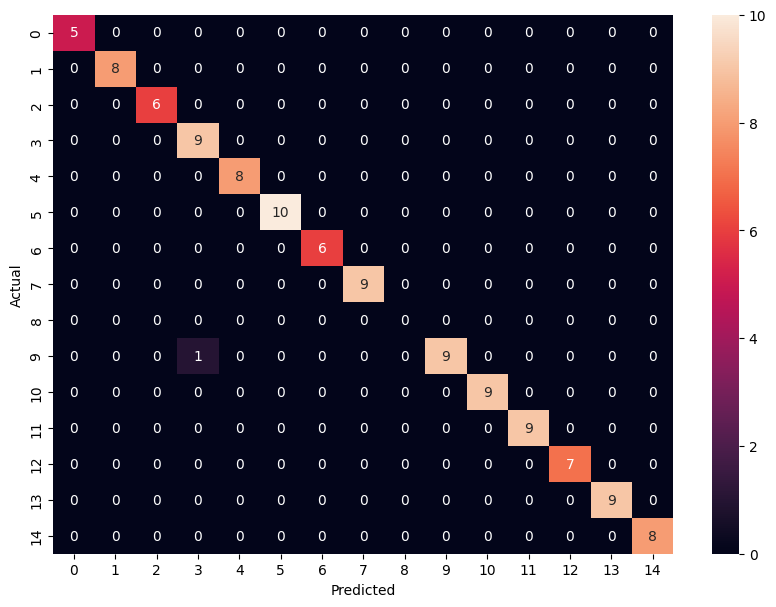

In [ ]:
# @title SVM Validation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# validation directory
test_dir = ("/content/drive/MyDrive/validation")


# Loop through each person in the testing directory
test_encodings = []
test_names = []
for person in os.listdir(test_dir):
    if person == ".DS_Store":
        continue
    person_dir = os.path.join(test_dir, person)
    if os.path.isdir(person_dir):
        pix = os.listdir(person_dir)

        # Loop through each training image for the current person
        for person_img in pix:
            # Get the face encodings for the face in each image file
            face = face_recognition.load_image_file(os.path.join(person_dir, person_img))
            face_bounding_boxes = face_recognition.face_locations(face)

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    test_names.append(person)
            else:
                print(person + "/" + person_img + " doesn't contain any faces.")

# Predict labels for the test dataset
pred_names = clf.predict(test_encodings)

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

faces/42_0.jpeg doesn't contain any faces.
Accuracy:  0.8976377952755905
                 precision    recall  f1-score   support

        Anirudh       1.00      1.00      1.00         4
        Aparnaa       0.80      1.00      0.89         4
           Chen       1.00      1.00      1.00         5
        Dheeraj       1.00      1.00      1.00         3
       Divyanth       1.00      1.00      1.00         5
        Griffin       0.50      1.00      0.67         2
        Haisong       0.57      1.00      0.73         4
        Haochen       1.00      1.00      1.00         4
          Huiyu       1.00      1.00      1.00         5
         Husain       1.00      1.00      1.00         5
        Kimsong       0.00      0.00      0.00         3
        Madhuri       1.00      1.00      1.00         2
          Manya       1.00      1.00      1.00         2
          Peiqi       1.00      1.00      1.00         5
          Pooja       0.62      1.00      0.77         5
         Prach

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


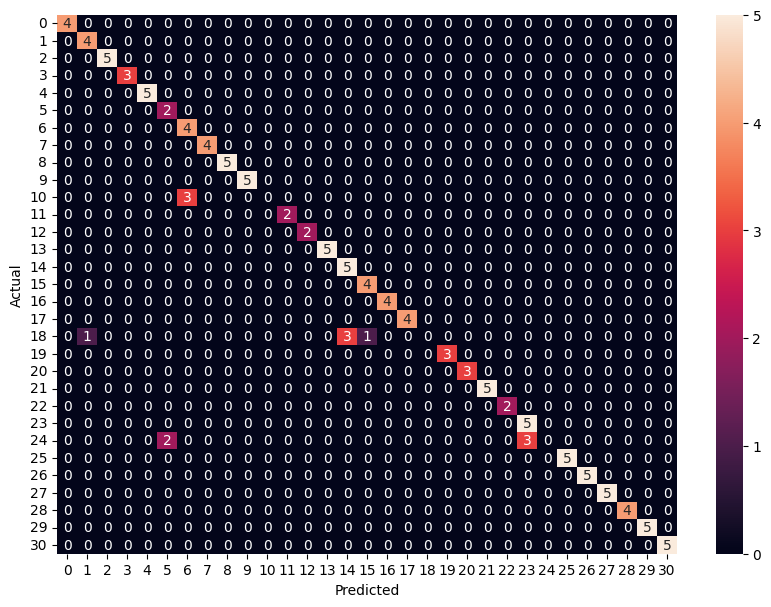

In [ ]:
# @title SVM TESTING
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import re

def numerical_sort(file_name):
    numbers = re.findall(r'\d+', file_name)
    if numbers:
        return int(numbers[0])
    return 0

# Testing directory
test_dir = ("/content/drive/MyDrive/COEN240")


# Loop through each person in the testing directory
test_encodings = []
test_names = []
for person in os.listdir(test_dir):
    if person == ".DS_Store":
        continue
    person_dir = os.path.join(test_dir, person)
    if os.path.isdir(person_dir):
        pix = os.listdir(person_dir)
        pix.sort(key=numerical_sort)
        # Loop through each training image for the current person
        with open('/content/drive/MyDrive/labels.txt', 'r') as file:
          filename=os.path.join(person_dir,".DS_Store")
          filename2=os.path.join(person_dir,"labels.txt")
          for line, person_img in zip(file, pix):
            if os.path.exists(filename):
                os.remove(filename)
            if os.path.exists(filename2):
                os.remove(filename2)
            # Get the face encodings for the face in each image file
            face = face_recognition.load_image_file(os.path.join(person_dir, person_img))
            face_bounding_boxes = face_recognition.face_locations(face)
            #image = cv2.imread(os.path.join(person_dir, person_img))

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    # Split the line at the dot ('.') and take the second part (the name)
                    # Also, strip any leading/trailing whitespaces
                    name = line.split()[1].strip()
                    # Add the name to the array
                    test_names.append(name)

            else:
                print(person + "/" + person_img + " doesn't contain any faces.")



'''# Open the file and read it line by line
with open('/content/drive/MyDrive/labels.txt', 'r') as file:
    for line in file:
        # Split the line at the dot ('.') and take the second part (the name)
        # Also, strip any leading/trailing whitespaces
        name = line.split()[1].strip()
        # Add the name to the array
        test_names.append(name)

# Print the array to verify the results
#print(names)
pred_names = clf.predict(test_encodings)
#print(pred_names)
#print(test_names)
images_dir = "/content/drive/MyDrive/Testing2/faces"
image_files = os.listdir(images_dir)
image_files.sort(key=numerical_sort)

for name, img in zip(pred_names, image_files):
    image_path = os.path.join(images_dir, img)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()
    print(name)
#print(pred_names)'''

pred_names = clf.predict(test_encodings)

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best score for data: 0.9967741935483871
Best C: 1
Best Kernel: rbf
Best Gamma: 10
Accuracy:  0.9291338582677166
                 precision    recall  f1-score   support

        Anirudh       1.00      1.00      1.00         4
        Aparnaa       1.00      1.00      1.00         4
           Chen       1.00      1.00      1.00         5
        Dheeraj       1.00      1.00      1.00         3
       Divyanth       1.00      1.00      1.00         5
        Griffin       1.00      1.00      1.00         2
        Haisong       1.00      1.00      1.00         4
        Haochen       1.00      1.00      1.00         4
          Huiyu       1.00      1.00      1.00         5
         Husain       1.00      1.00      1.00         5
        Kimsong       1.00      1.00      1.00         3
        Madhuri       1.00      1.00      1.00         2
          Manya       1.00      1.00      1.00         2
          Peiqi       1.00      1.00      1.00         5
          Pooja       0.56      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


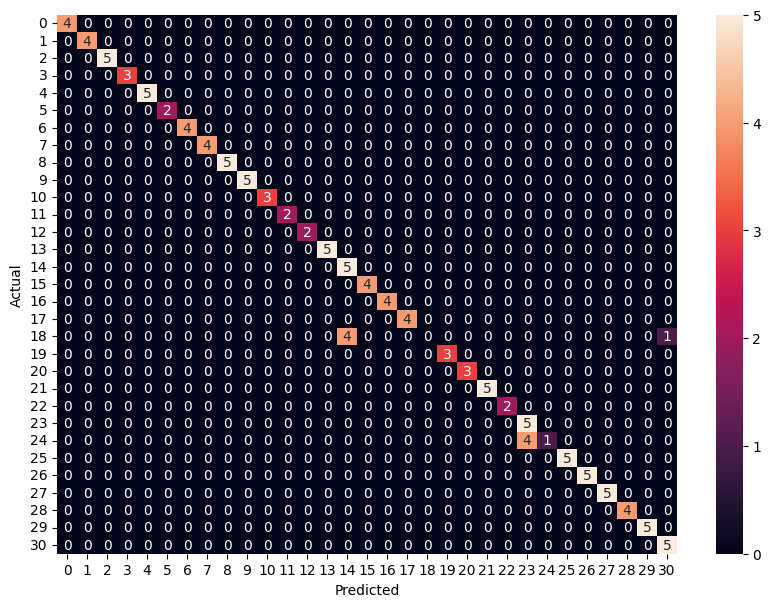

In [ ]:
# @title svm with hyperparameter tuning
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# Parameter grid
param_grid = [
  {'C': [0.001, 0.01, 1], 'kernel': ['linear']},
  {'C': [0.001, 0.01, 1], 'gamma': [1, 10, 100], 'kernel': ['rbf']},
]





# Create a classifier object with the classifier and parameter candidates
grid = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, cv=5)

# Train the classifier on data's feature and target data
grid.fit(encodings, names)

# View the accuracy score
print('Best score for data:', grid.best_score_)

# View the best parameters for the model found using grid search
print('Best C:',grid.best_estimator_.C)
print('Best Kernel:',grid.best_estimator_.kernel)
print('Best Gamma:',grid.best_estimator_.gamma)

# Predict labels for the test dataset
pred_names = grid.predict(test_encodings)

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Anirudh/0921-ClassPhotos _face_1.jpg doesn't contain any faces.
Anirudh/Screenshot 2023-10-21 at 9_face_0.jpg doesn't contain any faces.
Dheeraj/Dheeraj_cropped_09-26_1_face_1.jpg doesn't contain any faces.
Dheeraj/Dheeraj_cropped_09-28_3_face_0.jpg doesn't contain any faces.
Prachi/IMG_8551_face_1.jpg doesn't contain any faces.
Yuhang/week1-2_face_0.jpg doesn't contain any faces.
Accuracy:  1.0
                precision    recall  f1-score   support

       Anirudh       1.00      1.00      1.00         5
       Aparnaa       1.00      1.00      1.00         8
       Dheeraj       1.00      1.00      1.00         6
      Divyanth       1.00      1.00      1.00         9
        Husain       1.00      1.00      1.00         8
       Madhuri       1.00      1.00      1.00        10
        Prachi       1.00      1.00      1.00         6
         Ruthu       1.00      1.00      1.00         9
     Samyuktha       1.00      1.00      1.00         1
ShreyaDevendra       1.00      1.00     

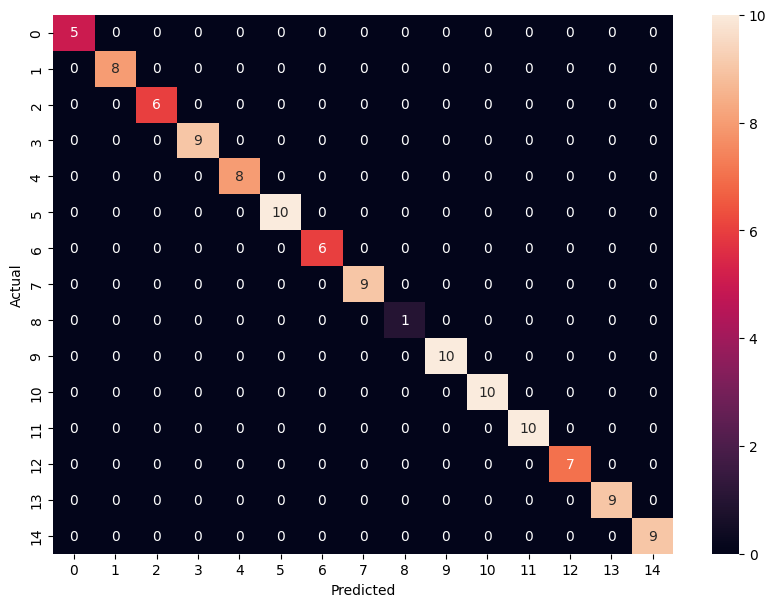

In [ ]:
# @title Knn validation testing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(encodings, names)

# validation directory
test_dir = ("/content/drive/MyDrive/validation")


# Loop through each person in the testing directory
test_encodings = []
test_names = []
for person in os.listdir(test_dir):
    if person == ".DS_Store":
        continue
    person_dir = os.path.join(test_dir, person)
    if os.path.isdir(person_dir):
        pix = os.listdir(person_dir)

        # Loop through each training image for the current person
        for person_img in pix:
            # Get the face encodings for the face in each image file
            face = face_recognition.load_image_file(os.path.join(person_dir, person_img))
            face_bounding_boxes = face_recognition.face_locations(face)

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    test_names.append(person)
            else:
                print(person + "/" + person_img + " doesn't contain any faces.")

# Predict labels for the test dataset
pred_names = knn.predict(test_encodings)

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

faces/42_0.jpeg doesn't contain any faces.
Accuracy:  0.984251968503937
                 precision    recall  f1-score   support

        Anirudh       1.00      1.00      1.00         4
        Aparnaa       1.00      1.00      1.00         4
           Chen       1.00      1.00      1.00         5
        Dheeraj       1.00      1.00      1.00         3
       Divyanth       1.00      1.00      1.00         5
        Griffin       1.00      1.00      1.00         2
        Haisong       1.00      1.00      1.00         4
        Haochen       1.00      1.00      1.00         4
          Huiyu       1.00      1.00      1.00         5
         Husain       1.00      1.00      1.00         5
        Kimsong       1.00      1.00      1.00         3
        Madhuri       1.00      1.00      1.00         2
          Manya       1.00      1.00      1.00         2
          Peiqi       1.00      1.00      1.00         5
          Pooja       1.00      1.00      1.00         5
         Prachi

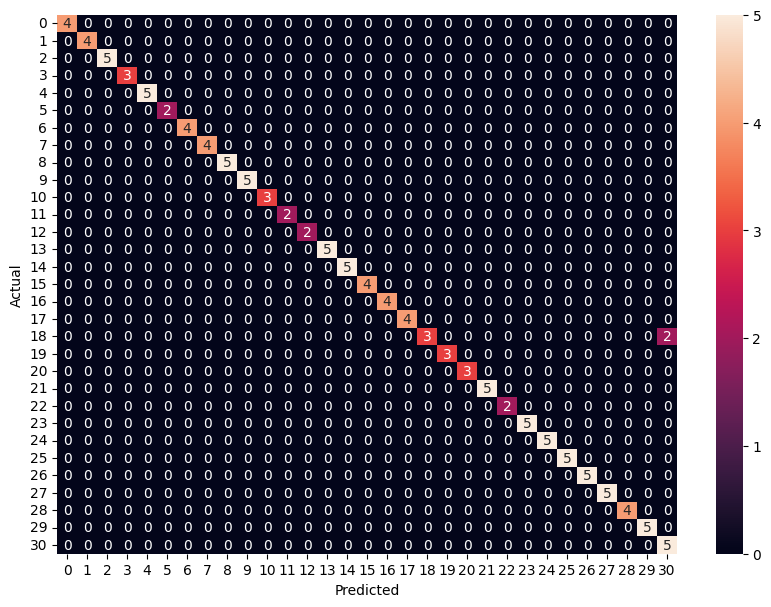

In [ ]:
# @title KNN
# Create and train the kNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(encodings, names)
def numerical_sort(file_name):
    numbers = re.findall(r'\d+', file_name)
    if numbers:
        return int(numbers[0])
    return 0


# Testing directory
test_dir = os.path.join("/content/drive/MyDrive/COEN240")

# Loop through each person in the testing directory
test_encodings = []
test_names = []
for person in os.listdir(test_dir):
    if person == ".DS_Store":
        continue
    person_dir = os.path.join(test_dir, person)
    if os.path.isdir(person_dir):
        pix = os.listdir(person_dir)
        pix.sort(key=numerical_sort)

        # Loop through each training image for the current person
        with open('/content/drive/MyDrive/labels.txt', 'r') as file:
          for line, person_img in zip(file, pix):
            # Get the face encodings for the face in each image file
            face = face_recognition.load_image_file(os.path.join(person_dir, person_img))
            face_bounding_boxes = face_recognition.face_locations(face)
            #image = cv2.imread(os.path.join(person_dir, person_img))

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    # Split the line at the dot ('.') and take the second part (the name)
                    # Also, strip any leading/trailing whitespaces
                    name = line.split()[1].strip()
                    # Add the name to the array
                    test_names.append(name)

            else:
                print(person + "/" + person_img + " doesn't contain any faces.")

# Predict labels for the test dataset
pred_names = knn.predict(test_encodings)
'''test_names = []

# Open the file and read it line by line
with open('/content/drive/MyDrive/labels.txt', 'r') as file:
    for line in file:
        # Split the line at the dot ('.') and take the second part (the name)
        # Also, strip any leading/trailing whitespaces
        name = line.split()[1].strip()
        # Add the name to the array
        test_names.append(name)'''

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

faces/42_0.jpeg doesn't contain any faces.
Accuracy:  0.9606299212598425
                 precision    recall  f1-score   support

        Anirudh       1.00      1.00      1.00         4
        Aparnaa       0.80      1.00      0.89         4
           Chen       1.00      1.00      1.00         5
        Dheeraj       1.00      1.00      1.00         3
       Divyanth       1.00      1.00      1.00         5
        Griffin       1.00      1.00      1.00         2
        Haisong       1.00      1.00      1.00         4
        Haochen       1.00      1.00      1.00         4
          Huiyu       1.00      1.00      1.00         5
         Husain       1.00      1.00      1.00         5
        Kimsong       1.00      1.00      1.00         3
        Madhuri       0.67      1.00      0.80         2
          Manya       1.00      1.00      1.00         2
          Peiqi       1.00      1.00      1.00         5
          Pooja       0.71      1.00      0.83         5
         Prach

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


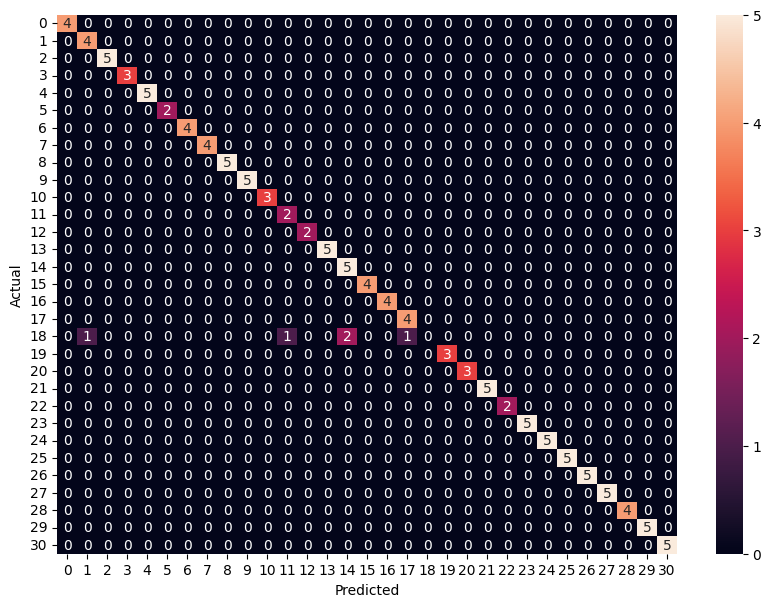

In [ ]:
# @title RANDOM FOREST
# Create and train the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(encodings, names)

# Testing directory
test_dir = os.path.join("/content/drive/MyDrive/COEN240")
def numerical_sort(file_name):
    numbers = re.findall(r'\d+', file_name)
    if numbers:
        return int(numbers[0])
    return 0


# Loop through each person in the testing directory
test_encodings = []
test_names = []
filename=os.path.join(person_dir,".DS_Store")
filename2=os.path.join(person_dir,"labels.txt")
for person in os.listdir(test_dir):
    person_dir = os.path.join(test_dir, person)
    if os.path.isdir(person_dir):
        pix = os.listdir(person_dir)
        pix.sort(key=numerical_sort)

        # Loop through each training image for the current person
        with open('/content/drive/MyDrive/labels.txt', 'r') as file:
          for line, person_img in zip(file, pix):
            # Get the face encodings for the face in each image file
            if os.path.exists(filename):
                os.remove(filename)
            if os.path.exists(filename2):
                os.remove(filename2)
            face = face_recognition.load_image_file(os.path.join(person_dir, person_img))
            face_bounding_boxes = face_recognition.face_locations(face)
            #image = cv2.imread(os.path.join(person_dir, person_img))

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    # Split the line at the dot ('.') and take the second part (the name)
                    # Also, strip any leading/trailing whitespaces
                    name = line.split()[1].strip()
                    # Add the name to the array
                    test_names.append(name)

            else:
                print(person + "/" + person_img + " doesn't contain any faces.")

# Predict labels for the test dataset
pred_names = rf.predict(test_encodings)
'''test_names = []

# Open the file and read it line by line
with open('/content/drive/MyDrive/labels.txt', 'r') as file:
    for line in file:
        # Split the line at the dot ('.') and take the second part (the name)
        # Also, strip any leading/trailing whitespaces
        name = line.split()[1].strip()
        # Add the name to the array
        test_names.append(name)'''

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# @title take_photo function call
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    # Define the directory to save the images
    image_dir = 'captured_images'

    # Create the directory if it doesn't exist
    os.makedirs(image_dir, exist_ok=True)

    # Save the image to the directory with a unique filename
    image_filename = os.path.join(image_dir, filename)
    with open(image_filename, 'wb') as f:
        f.write(binary)

    return image_filename

In [ ]:
'''# @title CAPTURE PHOTO
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  #display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))'''

<IPython.core.display.Javascript object>

Saved to captured_images/photo.jpg


<IPython.core.display.Javascript object>

Saved to captured_images/photo.jpg


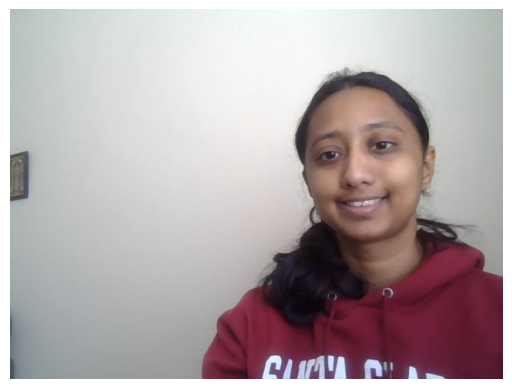

Ruthu


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  #display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(encodings, names)

# Testing directory
test_dir = ("/content/captured_images")
test_encodings = []
test_names = []
test_files = os.listdir(test_dir)
for person_img in test_files:
            # Get the face encodings for the face in each image file
            face = face_recognition.load_image_file(os.path.join(test_dir,person_img))
            face_bounding_boxes = face_recognition.face_locations(face)
            #image = cv2.imread(os.path.join(person_dir, person_img))

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    #test_names.append(person)

            else:
                print(person + "/" + person_img + " doesn't contain any faces.")

# Predict labels for the test dataset
pred_names = knn.predict(test_encodings)
images_dir = "/content/captured_images"
image_files = os.listdir(images_dir)
for name, img in zip(pred_names, image_files):
    image_path = os.path.join(images_dir, img)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()
    print(name)